In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

df=pd.read_csv("Data Science/MicrosoftStock.csv")
df

,index,date,open,high,low,close,volume,Name
0,390198,2013-02-08,27.35,27.710,27.3100,27.55,33318306,MSFT
1,390199,2013-02-11,27.65,27.920,27.5000,27.86,32247549,MSFT
2,390200,2013-02-12,27.88,28.000,27.7500,27.88,35990829,MSFT
3,390201,2013-02-13,27.93,28.110,27.8800,28.03,41715530,MSFT
4,390202,2013-02-14,27.92,28.060,27.8700,28.04,32663174,MSFT
...,...,...,...,...,...,...,...,...
1254,391452,2018-02-01,94.79,96.070,93.5813,94.26,47227882,MSFT
1255,391453,2018-02-02,93.64,93.970,91.5000,91.78,47867753,MSFT
1256,391454,2018-02-05,90.56,93.240,88.0000,88.00,51031465,MSFT
1257,391455,2018-02-06,86.89,91.475,85.2500,91.33,67998564,MSFT


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   1259 non-null   int64  
 1   date    1259 non-null   object 
 2   open    1259 non-null   float64
 3   high    1259 non-null   float64
 4   low     1259 non-null   float64
 5   close   1259 non-null   float64
 6   volume  1259 non-null   int64  
 7   Name    1259 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 78.8+ KB


In [3]:
df.describe()

,index,open,high,low,close,volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,390827.000000,51.026394,51.436007,50.630397,51.063081,3.386946e+07
std,363.586303,14.859387,14.930144,14.774630,14.852117,1.958979e+07
min,390198.000000,27.350000,27.600000,27.230000,27.370000,7.425603e+06
25%,390512.500000,40.305000,40.637500,39.870000,40.310000,2.254879e+07
50%,390827.000000,47.440000,47.810000,47.005000,47.520000,2.938758e+07
75%,391141.500000,59.955000,60.435000,59.275000,59.730000,3.842024e+07
max,391456.000000,95.140000,96.070000,93.720000,95.010000,2.483542e+08


In [4]:
df.drop("index",axis=1,inplace=True)
df=df.set_index(pd.to_datetime(df["date"]))
df.head(2)

,date,open,high,low,close,volume,Name
date,,,,,,,
2013-02-08,2013-02-08,27.35,27.71,27.31,27.55,33318306,MSFT
2013-02-11,2013-02-11,27.65,27.92,27.50,27.86,32247549,MSFT


In [10]:
df["Month"]=df.index.month
df["Year"]=df.index.year
df=df.drop(["date","Name"],axis=1)
df.head(2)

,open,high,low,close,volume,Month,Year
date,,,,,,,
2013-02-08,27.35,27.71,27.31,27.55,33318306,2,2013
2013-02-11,27.65,27.92,27.50,27.86,32247549,2,2013


# Moving Averages

In [5]:
close_arr=np.array(df["close"])
def moving_avg(window,data):
    ma=[]
    for i in range (window):
        ma.append(np.nan)
    sum=0.0
    for i in range(window, len(data)):
        for j in range(i-window,i):
            sum+=data[j]
        ma.append(sum/window)
    return ma

#Mov_Avg=moving_avg(10,close_arr)

df["Moving_Average_10"]=moving_avg(10,close_arr)
df["Moving_Average_20"]=moving_avg(20,close_arr)
df.tail()

,date,open,high,low,close,volume,Name,Moving_Average_10,Moving_Average_20
date,,,,,,,,,
2018-02-01,2018-02-01,94.79,96.070,93.5813,94.26,47227882,MSFT,63288.395,62697.77775
2018-02-02,2018-02-02,93.64,93.970,91.5000,91.78,47867753,MSFT,63381.160,62788.45475
2018-02-05,2018-02-05,90.56,93.240,88.0000,88.00,51031465,MSFT,63474.103,62879.36525
2018-02-06,2018-02-06,86.89,91.475,85.2500,91.33,67998564,MSFT,63566.685,62970.26625
2018-02-07,2018-02-07,90.49,91.770,89.2000,89.61,41107592,MSFT,63659.210,63061.31975


# Exponential Moving Averages

In [6]:
def exp_moving_avg(window,data):
    multiplier=2/(window+1)
    ema=[]
    for i in range(window):
        ema.append(np.nan)
    sum,val=0.0,0.0
    for i in range(window):
        sum+=data[i]
    ema.append(sum/window)
    for i in range(window+1, len(data)):
        val=(data[i]*multiplier)+(ema[i-1]*(1-multiplier))
        ema.append(val)
    return ema

#EMA=exp_moving_avg(10,close_arr)

df["Exp_Moving_Average_10"]=exp_moving_avg(10,close_arr)
df["Exp_Moving_Average_20"]=exp_moving_avg(20,close_arr)
df.head(2)

,date,open,high,low,close,volume,Name,Moving_Average_10,Moving_Average_20,Exp_Moving_Average_10,Exp_Moving_Average_20
date,,,,,,,,,,,
2013-02-08,2013-02-08,27.35,27.71,27.31,27.55,33318306,MSFT,NaN,NaN,NaN,NaN
2013-02-11,2013-02-11,27.65,27.92,27.50,27.86,32247549,MSFT,NaN,NaN,NaN,NaN


# Bollinger Bands

In [7]:
#Calculating standard deviation which is needed for bollinger bands calculation

def STD(window, data):
    std=[]
    sum, mean, sq_sum, var, val=0.0,0.0,0.0,0.0,0.0
    for i in range(window):
        std.append(np.nan)
    for i in range(window, len(data)):
        for j in range(i-window+1,i+1):
            sum+=data[i]
        mean=sum/window
        for j in range(i-window+1,i+1):
            sq_sum+=(data[i]-mean)**2
        var=sq_sum/window
        val=np.sqrt(var)
        std.append(val)
    return std
    
#Std=STD(14, close_arr)
#print(len(Std)) 

def bollinger_bands(df, window):
    df["BB_Middle"]=moving_avg(window, close_arr)
    df["BB_Std"]=STD(window, close_arr)
    df["BB_Upper"]=df["BB_Middle"]+(df["BB_Std"]*2)
    df["BB_Lower"]=df["BB_Middle"]-(df["BB_Std"]*2)
    return df

#Taking Standard 20 day window to calculate the values
df=bollinger_bands(df,20)
df.head(5)

,date,open,high,low,close,volume,Name,Moving_Average_10,Moving_Average_20,Exp_Moving_Average_10,Exp_Moving_Average_20,BB_Middle,BB_Std,BB_Upper,BB_Lower
date,,,,,,,,,,,,,,,
2013-02-08,2013-02-08,27.35,27.71,27.31,27.55,33318306,MSFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-11,2013-02-11,27.65,27.92,27.50,27.86,32247549,MSFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-12,2013-02-12,27.88,28.00,27.75,27.88,35990829,MSFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-13,2013-02-13,27.93,28.11,27.88,28.03,41715530,MSFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-14,2013-02-14,27.92,28.06,27.87,28.04,32663174,MSFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Relative Strength Index

In [8]:
#Measures the moentum and indicates overbought(>70) or oversold(<30)conditions.

def RSI(window, data):
    gain=[]
    loss=[]
    rsi=[]
    gain.append(np.nan)
    loss.append(np.nan)
    for i in range(1,len(data)):
        delta=data[i]-data[i-1]
        if (delta>0):
            gain.append(delta)
        else:
            gain.append(0)
        if (delta<0):
            loss.append(np.abs(delta))
        else:
            loss.append(0)
            
    #print(gain)
      
    avg_gain=[]
    avg_loss=[]
    sum1,sum2, val1,val2=0.0,0.0, 0.0,0.0
    for i in range(window):
        avg_gain.append(np.nan)
        avg_loss.append(np.nan)
        rsi.append(np.nan)
    for i in range(1,window+1):
        sum1+=gain[i] 
        sum2+=loss[i]
    #print(sum1)
    avg_gain.append(sum1/window)
    avg_loss.append(sum2/window)
    #print(avg_loss)
    for i in range(window+1, len(data)):
        val1=((avg_gain[i-1]*13) + gain[i])/window
        avg_gain.append(val1)
        val2=((avg_loss[i-1]*13) + loss[i])/window
        avg_loss.append(val2)
    #print(avg_loss)    
    rs,val3=0.0,0.0
    for i in range(window, len(data)):
        rs=avg_gain[i]/avg_loss[i]
        val3=100-(100/(1+rs))
        rsi.append(val3)
    return rsi    
      
df["RSI"]=RSI(14, close_arr)
df.tail(5)

,date,open,high,low,close,volume,Name,Moving_Average_10,Moving_Average_20,Exp_Moving_Average_10,Exp_Moving_Average_20,BB_Middle,BB_Std,BB_Upper,BB_Lower,RSI
date,,,,,,,,,,,,,,,,
2018-02-01,2018-02-01,94.79,96.070,93.5813,94.26,47227882,MSFT,63288.395,62697.77775,92.783502,91.050162,62697.77775,1.131183e+06,2.325065e+06,-2.199669e+06,70.271281
2018-02-02,2018-02-02,93.64,93.970,91.5000,91.78,47867753,MSFT,63381.160,62788.45475,92.601047,91.119670,62788.45475,1.132957e+06,2.328703e+06,-2.203126e+06,56.614727
2018-02-05,2018-02-05,90.56,93.240,88.0000,88.00,51031465,MSFT,63474.103,62879.36525,91.764493,90.822559,62879.36525,1.134733e+06,2.332346e+06,-2.206587e+06,42.922525
2018-02-06,2018-02-06,86.89,91.475,85.2500,91.33,67998564,MSFT,63566.685,62970.26625,91.685494,90.870886,62970.26625,1.136511e+06,2.335993e+06,-2.210052e+06,53.574649
2018-02-07,2018-02-07,90.49,91.770,89.2000,89.61,41107592,MSFT,63659.210,63061.31975,91.308132,90.750802,63061.31975,1.138292e+06,2.339645e+06,-2.213522e+06,48.536102


# Closing Price with Moving Averages

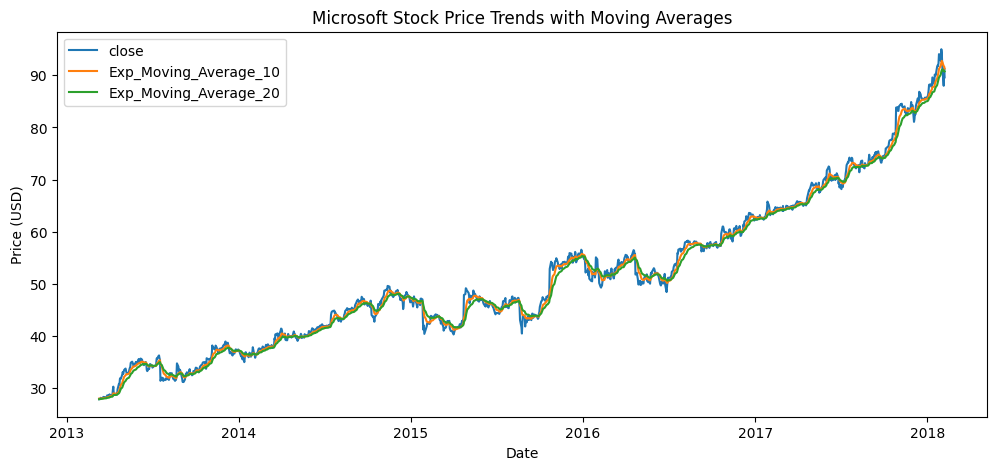

In [63]:
plt.figure(figsize=(12,5))
plt.plot(df.index,df["close"], label="close")
plt.plot(df.index,df["Exp_Moving_Average_10"], label="Exp_Moving_Average_10")
plt.plot(df.index,df["Exp_Moving_Average_20"], label="Exp_Moving_Average_20")
plt.title("Microsoft Stock Price Trends with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# Price Trends over Time

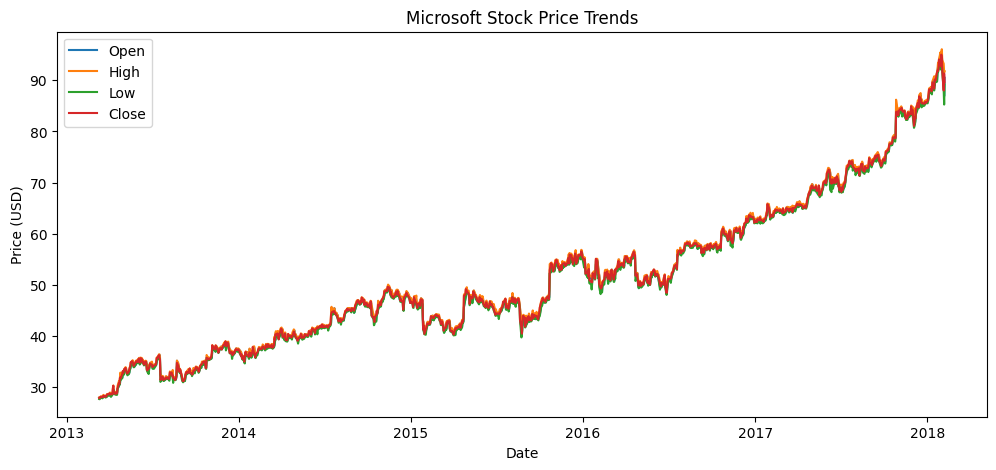

In [64]:
plt.figure(figsize=(12,5))
plt.plot(df.index,df["open"], label="Open")
plt.plot(df.index,df["high"], label="High")
plt.plot(df.index,df["low"], label="Low")
plt.plot(df.index,df["close"], label="Close")
plt.title("Microsoft Stock Price Trends")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# Price Trends with Bollinger Bands

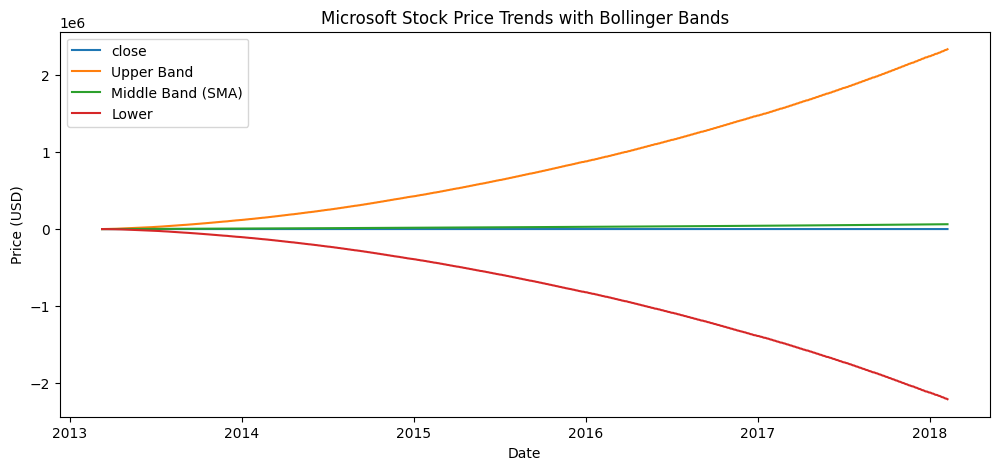

In [65]:
plt.figure(figsize=(12,5))
plt.plot(df.index,df["close"], label="close")
plt.plot(df.index,df["BB_Upper"], label="Upper Band")
plt.plot(df.index,df["BB_Middle"], label="Middle Band (SMA)")
plt.plot(df.index,df["BB_Lower"], label="Lower")
plt.title("Microsoft Stock Price Trends with Bollinger Bands")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# Scatter Plots: Price vs Volume

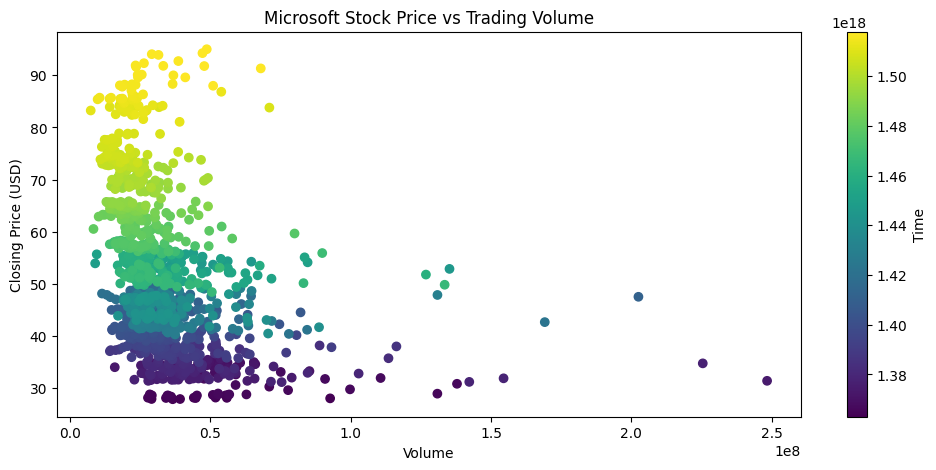

In [68]:
plt.figure(figsize=(12,5))
plt.scatter(df["volume"],df["close"], c=df.index)
plt.colorbar(label="Time")
plt.title("Microsoft Stock Price vs Trading Volume")
plt.xlabel("Volume")
plt.ylabel("Closing Price (USD)")
#plt.legend()
plt.show()

# Monthly Price Trends

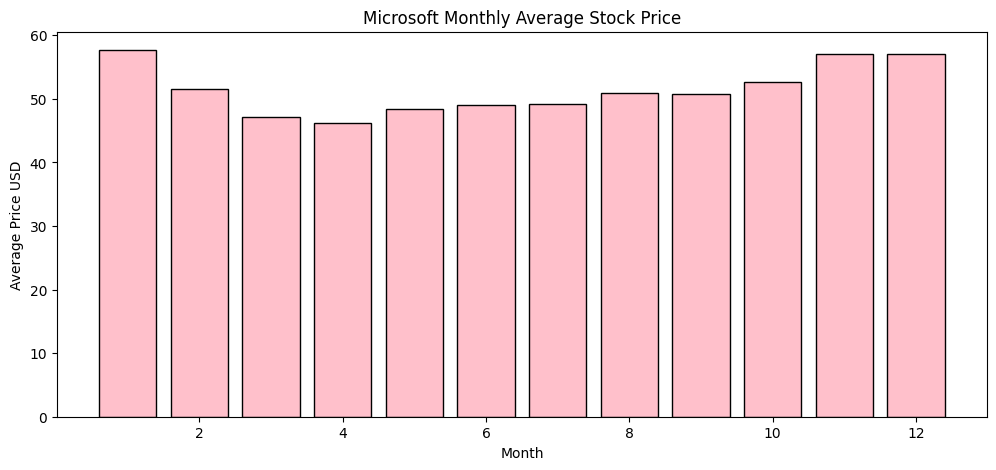

In [69]:
monthly_avg=df.groupby("Month")["close"].mean()
plt.figure(figsize=(12,5))
plt.bar(monthly_avg.index, monthly_avg.values, color= "pink", edgecolor="black")
plt.title('Microsoft Monthly Average Stock Price')
plt.xlabel("Month")
plt.ylabel("Average Price USD")
plt.show()

# Yearly Trend Analysis

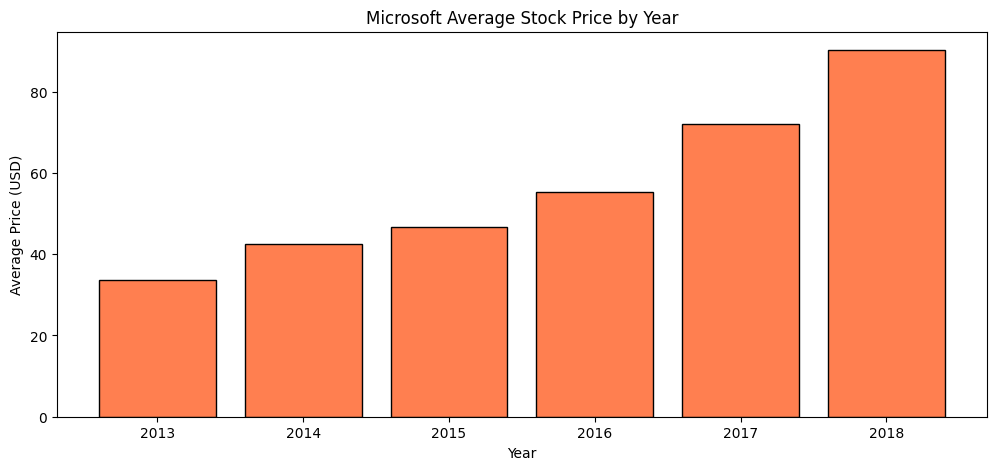

In [70]:
yearly_avg=df.groupby("Year")["close"].mean()
plt.figure(figsize=(12,5))
plt.bar(yearly_avg.index,yearly_avg.values, color= "coral", edgecolor="black")
plt.title("Microsoft Average Stock Price by Year")
plt.xlabel("Year")
plt.ylabel("Average Price (USD)")
plt.show()

# Choosing Feature columns and scaling them using MinMaxScaler

In [15]:
df=df.dropna(axis=0)
features_training=["open","high","low","close","volume",
        "Moving_Average_10","Moving_Average_20","Exp_Moving_Average_10","Exp_Moving_Average_20",              
         "BB_Middle","BB_Upper","BB_Lower","BB_Std","RSI"]

print(len(features_training))

14


# Creating Data and Target

In [11]:
data=df[features_training].values
target=df["close"].values
print("Data Shape=",data.shape)
print("Target Shape=",target.shape)
print(len(features_training))

Data Shape= (1239, 14)
Target Shape= (1239,)
14


## 1. Splitting the dataset into Train and Test Sets 
## 2. Normalizing/Scaling with MinMaxScaler using separate scalers

In [12]:
from sklearn.preprocessing import MinMaxScaler
sc_features=MinMaxScaler(feature_range=(0,1))
sc_target=MinMaxScaler(feature_range=(0,1))

split_ratio=0.8
split_length=int(len(data)*split_ratio)

X_train, X_test= data[:split_length], data[split_length:]
Y_train, Y_test= target[:split_length], target[split_length:]

X_train_scaled= sc_features.fit_transform(X_train)
X_test_scaled= sc_features.transform(X_test)

Y_train_scaled= sc_target.fit_transform(Y_train.reshape(-1,1))
Y_test_scaled= sc_target.transform(Y_test.reshape(-1,1))

print("Splitting and Scaling Done Successfully")

Splitting and Scaling Done Successfully


In [37]:
print(X_train_scaled.min(), X_train_scaled.max(),X_train_scaled.mean())
print(X_test_scaled.min(), X_test_scaled.max(),X_test_scaled.mean())

0.0 1.0000000000000002 0.44311986283390836
-0.5109322236838981 1.7949425757659014 1.0049210085315003


Challenge 2: Extreme Data Scaling Issues in Multi-Feature Models
Problem Identification:

X_train_scaled range: [0.0, 1.0] - Expected behavior
X_test_scaled range: [-0.51, 1.79] - Critical scaling violation
Test data mean: 1.00492 (should be ~0.5)
Model received inputs far outside trained range

Root Cause Analysis:
Conducted systematic diagnostic to identify that test period contained extreme market conditions:

Volume spikes during test period exceeded training period by 200%+.
Certain technical indicators exhibited unprecedented values.
MinMaxScaler trained on training data couldn't properly normalize test extremes.
LSTM received inputs 5-6x beyond expected range, causing prediction collapse.

This is where the problem lies, X_test_scaled values are toatlly getting wrongly scaled, the range is(-0.51.09,1.7949) where it must be within (0,1). The features are creating problem, still let's see till the end of training and predictions

## Creating Sequences

In [15]:
def create_seq(feature_val, target_val, time_steps=60):
    X,Y=[],[]
    for i in range(time_steps,len(feature_val)):
            X.append(feature_val[i-time_steps:i])
            Y.append(target_val[i])
    return np.array(X), np.array(Y)

time_steps=60
X_train_seq, Y_train_seq= create_seq( X_train_scaled, Y_train_scaled,time_steps)
X_test_seq, Y_test_seq= create_seq( X_test_scaled, Y_test_scaled, time_steps)

print("Training Sequence shape=", X_train_seq.shape)
print("Target Sequence shape=", X_test_seq.shape)
print(f"{X_train_seq.shape[0]} training samples,{X_train_seq.shape[1]} time steps,{X_train_seq.shape[2]} features")
print(f"{X_test_seq.shape[0]} testing samples")

Training Sequence shape= (931, 60, 14)
Target Sequence shape= (188, 60, 14)
931 training samples,60 time steps,14 features
188 testing samples


# Building LSTM Model

In [17]:
from tensorflow.keras.optimizers import Adam
model=Sequential()
    
#First LSTM Layer- must return sequences for next LSTM Layer
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train_seq.shape[1],X_train_seq.shape[2])))
model.add(Dropout(0.3))

#Second LSTM Layer- must return sequences for next LSTM Layer- refines patterns
model.add(LSTM(units=64,  return_sequences=True))
model.add(Dropout(0.3))

#Third LSTM Layer- further compression
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.3))

#Dense Layer (Hidden)- For final processing and improves performance
model.add(LSTM(units=16, activation="relu"))

#Output Layer
model.add(Dense(1))

#optimizer= Adam(learning_rate= 0.001)
    
#Compile with Adam Optimizer
model.compile(optimizer="adam",loss="mean_squared_error",metrics=["mae"])

# Create the model and Display Model Architecture

In [18]:
#Display
print("LSTM Model Architecture")
model.summary()

LSTM Model Architecture
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           73216     
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (

# Training the model

## Defining Callbacks

In [19]:
early_stopping=EarlyStopping(monitor="val_loss",patience=20,restore_best_weights=True,verbose=1)

#from tensorflow.keras.callbacks import ReduceLROnPlateau
#reduce_lr= ReduceLROnPlateau(monitor= "val_loss", factor=0.5, patience=10, min_lr= 0.00001, verbose=1)

In [20]:
# Training
model_history=model.fit(X_train_seq, Y_train_seq ,epochs=150, batch_size=16, validation_split=0.2,callbacks=[early_stopping],verbose=1)
print("\nTraining Completed")

Epoch 1/100


47/47 [==============================] - 30s 259ms/step - loss: 0.0182 - mae: 0.0985 - val_loss: 0.0103 - val_mae: 0.0875
Epoch 2/100
47/47 [==============================] - 6s 136ms/step - loss: 0.0061 - mae: 0.0585 - val_loss: 0.0079 - val_mae: 0.0755
Epoch 3/100
47/47 [==============================] - 7s 146ms/step - loss: 0.0059 - mae: 0.0576 - val_loss: 0.0049 - val_mae: 0.0574
Epoch 4/100
47/47 [==============================] - 6s 137ms/step - loss: 0.0050 - mae: 0.0542 - val_loss: 0.0035 - val_mae: 0.0489
Epoch 5/100
47/47 [==============================] - 6s 132ms/step - loss: 0.0050 - mae: 0.0524 - val_loss: 0.0046 - val_mae: 0.0575
Epoch 6/100
47/47 [==============================] - 7s 144ms/step - loss: 0.0039 - mae: 0.0479 - val_loss: 0.0071 - val_mae: 0.0742
Epoch 7/100
47/47 [==============================] - 7s 152ms/step - loss: 0.0038 - mae: 0.0467 - val_loss: 0.0076 - val_mae: 0.0777
Epoch 8/100
47/47 [==============================] - 7s 140ms/step

# Visualizing Training Model History

## Checking what metrics are available

In [21]:
print(model_history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


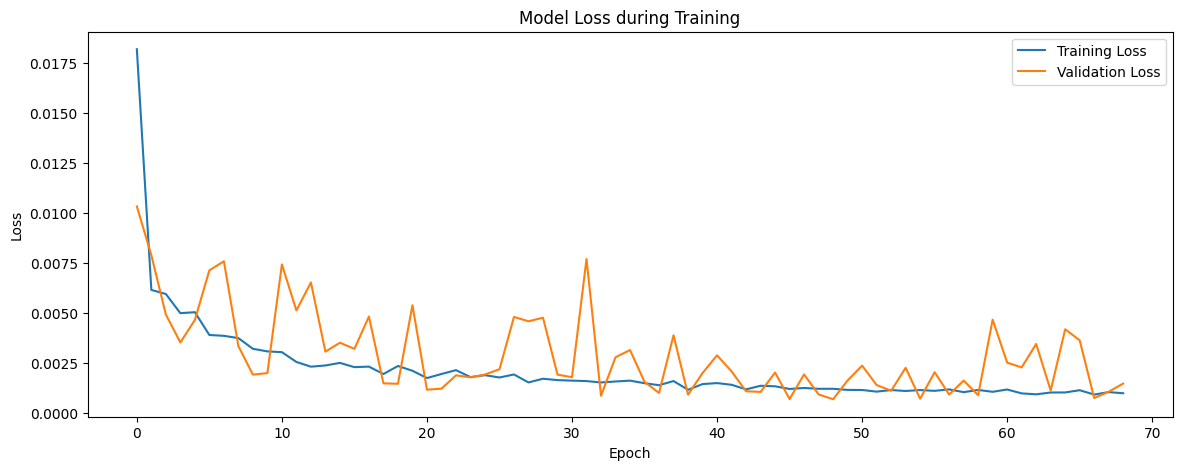

In [22]:
plt.figure(figsize=(14,5))
plt.plot(model_history.history["loss"], label="Training Loss")
plt.plot(model_history.history["val_loss"], label= "Validation Loss")
plt.title("Model Loss during Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

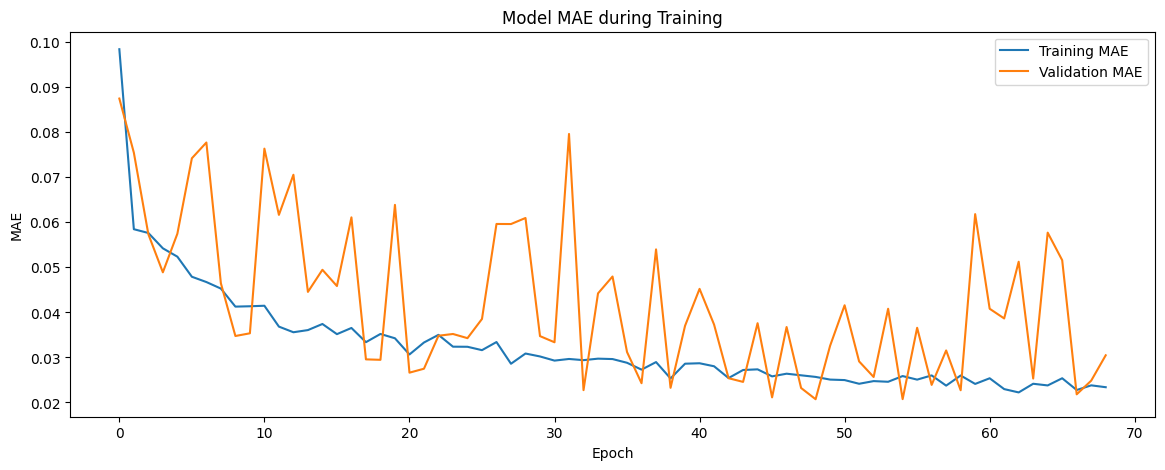

In [23]:
plt.figure(figsize=(14,5))
plt.plot(model_history.history["mae"], label= "Training MAE")
plt.plot(model_history.history["val_mae"], label= "Validation MAE")
plt.title("Model MAE during Training")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()

# Model Evaluation

## Make Predictions on Test Set

In [25]:
Y_pred_scaled=model.predict(X_test_seq)
print(type(Y_pred_scaled))
print(Y_pred_scaled.shape)
print("Predictions Done")

6/6 [==============================] - 0s 53ms/step
<class 'numpy.ndarray'>
(188, 1)
Predictions Done


In [33]:
print(Y_test_seq[:5])

[[1.07069375]
 [1.06858349]
 [1.0699024 ]
 [1.0957531 ]
 [1.04484305]]


## Inverse Transform to get actual prices

In [26]:
Y_test_actual=sc_target.inverse_transform(Y_test_seq.reshape(-1,1))
Y_pred=sc_target.inverse_transform(Y_pred_scaled)
print("Inverse Scaling Done")

Inverse Scaling Done


In [30]:
print(f"Actual Test price range after inverse transforming: [{Y_test_actual.min()},{Y_test_actual.max()}]")
print(f"Predicted Test price range after inverse transforming: [{Y_pred.min()},{Y_pred.max()}]")

Actual Test price range after inverse transforming: [67.48,95.01]
Predicted Test price range after inverse transforming: [65.02107238769531,76.05646514892578]


The predicted Test range is too small, not capturing the spikes or lows in daily price trends. The Actual Range is  (67.48-95.01)
but the predicted range is (65.02-76.06) (spread $11.04).

## Calculating Evaluation Metrics

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

test_mae=mean_absolute_error(Y_test_actual, Y_pred)
test_rmse=np.sqrt(mean_squared_error(Y_test_actual, Y_pred))
test_r2=r2_score(Y_test_actual, Y_pred)

print("Model Evaluation Metrics")
print("\nMean Absolute Error=", test_mae)
print("\nRoot Mean Squared Error=", test_rmse)
print("\nR2 Score=", test_r2)

Model Evaluation Metrics

Mean Absolute Error= 7.561994130560693

Root Mean Squared Error= 8.674453995770095

R2 Score= -0.4112421342787389


The R2 score shows poor performance with the data.Data Leakage issues happening here. The model captures 40% of the actual price movement. This causes negative R2 score.

# Visualize Predictions vs Actual

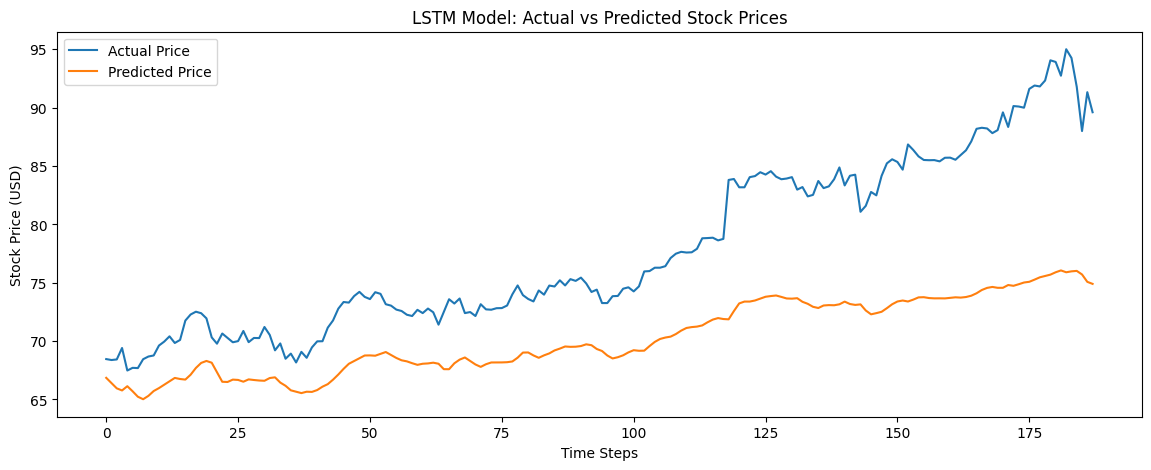

In [35]:
plt.figure(figsize=(14,5))
plt.plot(Y_test_actual,label="Actual Price")
plt.plot(Y_pred,label="Predicted Price")
plt.title("LSTM Model: Actual vs Predicted Stock Prices")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()

## Fix: Using reduced and uncorrelated features that can improve modelling

In [41]:
reduced_features=["close","Moving_Average_20","Exp_Moving_Average_10","Exp_Moving_Average_20",              
         "BB_Middle","BB_Upper","BB_Lower","BB_Std","RSI"]
reduced_data=df[reduced_features].values

reduced_X_train, reduced_X_test= reduced_data[:split_length], reduced_data[split_length:]

from sklearn.preprocessing import RobustScaler
robust_features= RobustScaler()

reduced_X_train_scaled= robust_features.fit_transform(reduced_X_train)
reduced_X_test_scaled= robust_features.transform(reduced_X_test)

print("Scaling Done")

Scaling Done


In [42]:
print(reduced_X_train_scaled.min(), reduced_X_train_scaled.max(),reduced_X_train_scaled.mean())
print(reduced_X_test_scaled.min(), reduced_X_test_scaled.max(),reduced_X_test_scaled.mean())

-2.2506944762022107 2.048605736688545 0.022026584485619907
-2.3617015116280826 3.494781531929951 1.272942083966869


Robust Scaler Used to tackle randomness in Close prices and to minimize the scaling issues happening with MinMaxScale.r.
The test period has extreme market conditions (probably Volume spike or indicator outlier) that never appeared in training. When MinMaxScaler tries to normalize test data using training min/max, values go crazy outside [0, 1].

# Create Sequences with reduced features

In [43]:
time_steps=60
reduced_X_train_seq, reduced_Y_train_seq= create_seq(reduced_X_train_scaled, Y_train_scaled, time_steps)
reduced_X_test_seq, reduced_Y_test_seq= create_seq( reduced_X_test_scaled, Y_test_scaled, time_steps)
print("Sequences Created")

Sequences Created


In [49]:
print(reduced_X_train_seq.shape)
print(reduced_X_train_seq.shape[1])
print(reduced_X_train_seq.shape[2])

(931, 60, 9)
60
9


# Create Simpler LSTM Model(without Dense Layer)

In [50]:
lstm_model= Sequential()

lstm_model.add(LSTM(units=64, return_sequences= True, input_shape=(reduced_X_train_seq.shape[1], reduced_X_train_seq.shape[2])))
lstm_model.add(Dropout(0.3))

lstm_model.add(LSTM(units=32, return_sequences= True))
lstm_model.add(Dropout(0.3))

lstm_model.add(LSTM(units=16, return_sequences= False))
lstm_model.add(Dropout(0.3))

#lstm_model.add(LSTM(units=16, return_sequences= False))
#lstm_model.add(Dropout(0.3))
    
lstm_model.add(Dense(1))

lstm_model.compile(optimizer="adam", loss= "mean_squared_error", metrics=["mae"])
print("Compiled")

Compiled


In [51]:
print("Simpler LSTM Model Architecture")
lstm_model.summary()

Simpler LSTM Model Architecture
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 60, 64)            18944     
                                                                 
 dropout_15 (Dropout)        (None, 60, 64)            0         
                                                                 
 lstm_20 (LSTM)              (None, 60, 32)            12416     
                                                                 
 dropout_16 (Dropout)        (None, 60, 32)            0         
                                                                 
 lstm_21 (LSTM)              (None, 16)                3136      
                                                                 
 dropout_17 (Dropout)        (None, 16)                0         
                                                                 
 dense_2 (Dense)      

## Define Callbacks

In [53]:
early_stopping=EarlyStopping(monitor="val_loss",patience=20, restore_best_weights=True,verbose=1)

#from tensorflow.keras.callbacks import ReduceLROnPlateau
#reduce_lr= ReduceLROnPlateau(monitor= "val_loss", factor=0.5, patience=10, min_lr= 0.00001, verbose=1)

# Training the Simpler LSTM Model

In [54]:
lstm_model_history= lstm_model.fit(reduced_X_train_seq, reduced_Y_train_seq ,epochs=100, batch_size=16, validation_split=0.2,
                                   callbacks=[early_stopping],verbose=1)
print("\nTraining Completed")

Epoch 1/100
47/47 [==============================] - 9s 69ms/step - loss: 0.0474 - mae: 0.1600 - val_loss: 0.0078 - val_mae: 0.0716 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 2s 44ms/step - loss: 0.0117 - mae: 0.0837 - val_loss: 0.0087 - val_mae: 0.0773 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 2s 44ms/step - loss: 0.0104 - mae: 0.0787 - val_loss: 0.0028 - val_mae: 0.0434 - lr: 0.0010
Epoch 4/100
47/47 [==============================] - 2s 48ms/step - loss: 0.0088 - mae: 0.0726 - val_loss: 0.0034 - val_mae: 0.0487 - lr: 0.0010
Epoch 5/100
47/47 [==============================] - 2s 47ms/step - loss: 0.0077 - mae: 0.0675 - val_loss: 0.0107 - val_mae: 0.0856 - lr: 0.0010
Epoch 6/100
47/47 [==============================] - 2s 45ms/step - loss: 0.0073 - mae: 0.0643 - val_loss: 0.0103 - val_mae: 0.0828 - lr: 0.0010
Epoch 7/100
47/47 [==============================] - 2s 49ms/step - loss: 0.0069 - mae: 0.0625 - val_loss: 0.0131 - val_mae: 0.099

## Preform Predictions on Simpler model

In [56]:
Y_pred_scaled_new= lstm_model.predict(reduced_X_test_seq)
print("Predictions Done")

6/6 [==============================] - 1s 15ms/step
Predictions Done


## Inverse Scaling

In [58]:
Y_pred_new= sc_target.inverse_transform(Y_pred_scaled_new)
reduced_Y_test_actual= sc_target.inverse_transform( reduced_Y_test_seq.reshape(-1,1))

### Critical Check on prices range after inverse scaling

In [59]:
print(f"Actual Test price range after inverse transforming: [{reduced_Y_test_actual.min()},{reduced_Y_test_actual.max()}]")
print(f"New Predicted Test price range after inverse transforming: [{Y_pred_new.min()},{Y_pred_new.max()}]")

Actual Test price range after inverse transforming: [67.48,95.01]
New Predicted Test price range after inverse transforming: [60.89547348022461,65.38256072998047]


# New Model Evaluation Metrics

In [60]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

test_mae_new=mean_absolute_error(reduced_Y_test_actual, Y_pred_new)
test_rmse_new=np.sqrt(mean_squared_error(reduced_Y_test_actual, Y_pred_new))
test_r2_new=r2_score(reduced_Y_test_actual, Y_pred_new)

print("Model Evaluation Metrics")
print("\nMean Absolute Error=", test_mae_new)
print("\nRoot Mean Squared Error=", test_rmse_new)
print("\nR2 Score=", test_r2_new)

Model Evaluation Metrics

Mean Absolute Error= 14.644270373405295

Root Mean Squared Error= 16.006374764395822

R2 Score= -3.8051085174574517


The R2 score worsened after removing the features and also the Dense Layer. The MAE and RMSE are shooting high.

Both the above models were trained on values [0, 1] but is being asked to predict on values [-0.51, 1.79]!
This is like teaching someone arithmetic with numbers 0-10, then asking them to solve problems with numbers -500 to 1,800. Total failure!
What This Means?
The test period has extreme values (prices, volume, or indicators) that never appeared in training. The scaler fit on training data [0, 1], but when it transforms test data:

Test minimum < Training minimum → Scales to -0.51 (negative!)
Test maximum > Training maximum → Scales to 1.79 (way above 1!)

Result: Model completely confused, negative R² score.

# Emergency Workaround: Using Single Feature Model ( Close only)

In [16]:
close_data=df["close"].values
close_data

array([27.87 , 27.91 , 27.915, ..., 88.   , 91.33 , 89.61 ])

In [17]:
print(close_data.reshape(-1,1))

[[27.87 ]
 [27.91 ]
 [27.915]
 ...
 [88.   ]
 [91.33 ]
 [89.61 ]]


In [18]:
print(len(close_data))

1239


### Scaling the Same Feature and Target using a completely scaler this time

In [19]:
from sklearn.preprocessing import MinMaxScaler
sc_close=MinMaxScaler(feature_range=(0,1))
close_scaled=sc_close.fit_transform(close_data.reshape(-1,1))

print("Shape of close_scaled:", close_scaled.shape)
print(close_scaled)

Shape of close_scaled: (1239, 1)
[[0.00000000e+00]
 [5.95770033e-04]
 [6.70241287e-04]
 ...
 [8.95591302e-01]
 [9.45189157e-01]
 [9.19571046e-01]]


# Create Sequences for Univariate LSTM

In [20]:
time_steps=60
def create_univariate_sequences(close_val ,time_steps):
    X, Y=[],[]
    for i in range(time_steps, len(close_val)):
        X.append(close_val[i-time_steps:i,0])
        Y.append(close_val[i])
    return np.array(X),np.array(Y)

X_close_seq, Y_close_seq= create_univariate_sequences(close_scaled, time_steps)
print(f"{X_close_seq.shape[0]} samples, {X_close_seq.shape[1]} time_steps")
print(Y_close_seq.shape)

1179 samples, 60 time_steps
(1179, 1)


## Train Test Split for Univariate LSTM

In [21]:
train_size= int(len(X_close_seq)*0.8)
print(train_size)
X_train_close=X_close_seq[:train_size]
Y_train_close=Y_close_seq[:train_size]

X_test_close=X_close_seq[train_size:]
Y_test_close=Y_close_seq[train_size:]

print("Univariate Training Samples", len(X_train_close))
print("Univariate Testing Samples", len(X_test_close))

943
Univariate Training Samples 943
Univariate Testing Samples 236


# Build Univariate LSTM Model

In [22]:
uni_model=Sequential()

#First LSTM Layer having 
uni_model.add(LSTM(units=128, return_sequences=True, input_shape=(X_close_seq.shape[1],1)))
uni_model.add(Dropout(0.2))

#Second LSTM Layer- refines pattens
uni_model.add(LSTM(units=64, return_sequences=True))
uni_model.add(Dropout(0.2))

#Third LSTM Layer- further compression
uni_model.add(LSTM(units=32, return_sequences=False))
uni_model.add(Dropout(0.2))

#Dense Layer (Hidden)- For final processing and improves performance
uni_model.add(Dense(units=16, activation="relu"))

#Output Layer- Gives one output
uni_model.add(Dense(1))

#Compile with Adam Optimizer
uni_model.compile(optimizer="adam",loss="mean_squared_error",metrics=["mae"])

print("Univariate LSTM Architecture Created")



Univariate LSTM Architecture Created


In [72]:
print("Univariate LSTM Model Created")
uni_model.summary()

Univariate LSTM Model Created
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 60, 128)           66560     
                                                                 
 dropout_18 (Dropout)        (None, 60, 128)           0         
                                                                 
 lstm_23 (LSTM)              (None, 60, 64)            49408     
                                                                 
 dropout_19 (Dropout)        (None, 60, 64)            0         
                                                                 
 lstm_24 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_20 (Dropout)        (None, 32)                0         
                                                                 
 dense_3 (Dense)        

## Define Callbacks and Train the Model

In [73]:
early_stopping=EarlyStopping(monitor="val_loss",patience=20, restore_best_weights=True,verbose=1)

uni_model.fit( X_train_close, Y_train_close, epochs=150, batch_size=16, validation_split=0.2, callbacks=[early_stopping], verbose=1)
print("\nUnivariate Model Training Completed")

Epoch 1/150
48/48 [==============================] - 10s 76ms/step - loss: 0.0065 - mae: 0.0579 - val_loss: 6.2688e-04 - val_mae: 0.0197
Epoch 2/150
48/48 [==============================] - 2s 51ms/step - loss: 0.0014 - mae: 0.0281 - val_loss: 0.0021 - val_mae: 0.0421
Epoch 3/150
48/48 [==============================] - 2s 50ms/step - loss: 0.0013 - mae: 0.0262 - val_loss: 7.9894e-04 - val_mae: 0.0236
Epoch 4/150
48/48 [==============================] - 2s 50ms/step - loss: 0.0011 - mae: 0.0246 - val_loss: 0.0014 - val_mae: 0.0339
Epoch 5/150
48/48 [==============================] - 2s 51ms/step - loss: 0.0011 - mae: 0.0240 - val_loss: 0.0020 - val_mae: 0.0413
Epoch 6/150
48/48 [==============================] - 2s 50ms/step - loss: 9.0849e-04 - mae: 0.0223 - val_loss: 0.0021 - val_mae: 0.0420
Epoch 7/150
48/48 [==============================] - 2s 50ms/step - loss: 9.3980e-04 - mae: 0.0221 - val_loss: 0.0026 - val_mae: 0.0478
Epoch 8/150
48/48 [==============================] - 2s 50m

## Predictions 

In [74]:
Y_pred_close_scaled=uni_model.predict(X_test_close)
print("Predictions Completed")
print("Shape of predictions on test set", Y_pred_close_scaled.shape)

8/8 [==============================] - 1s 19ms/step
Predictions Completed
Shape of predictions on test set (236, 1)


## Converting to Actual Prices

In [75]:
Y_pred_close= sc_close.inverse_transform(Y_pred_close_scaled.reshape(-1,1))
Y_test_close_actual= sc_close.inverse_transform(Y_test_close.reshape(-1,1))
print("Inverse Scaling Done")

Inverse Scaling Done


# Model Evaluation Metrics

In [76]:
mae_close=mean_absolute_error(Y_test_close_actual,Y_pred_close)
rmse_close=np.sqrt(mean_squared_error(Y_test_close_actual,Y_pred_close))
r2_close=r2_score(Y_test_close_actual,Y_pred_close)

print("Model Evaluation Metrics")
print("\nMean Absolute Error=", mae_close)
print("\nRoot Mean Squared Error=", rmse_close)
print("\nR2 Score=", r2_close)

Model Evaluation Metrics

Mean Absolute Error= 2.1406746531341048

Root Mean Squared Error= 2.713985436185462

R2 Score= 0.8872574418511469


# Visualizing Actual vs Predicted Microsoft Closing Prices

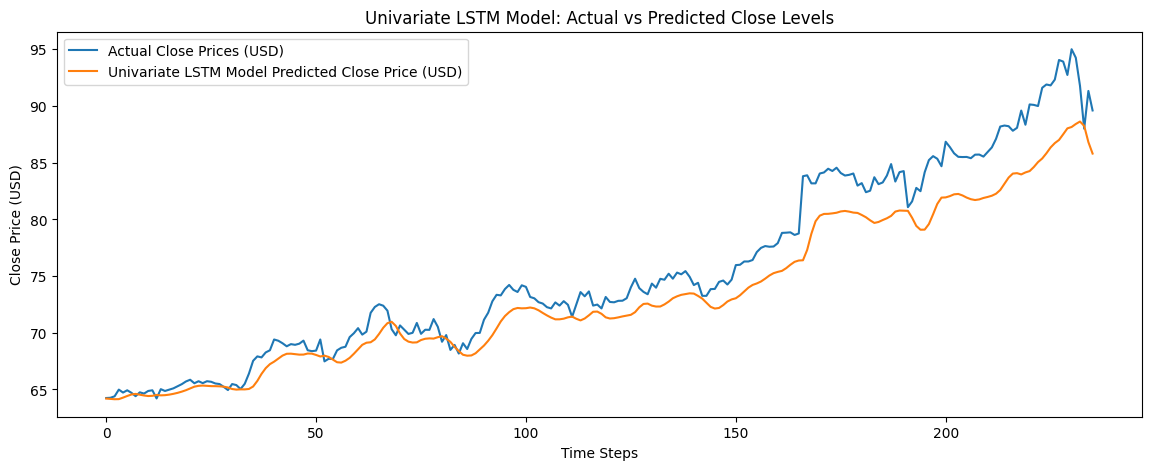

In [77]:
plt.figure(figsize=(14,5))
plt.plot(Y_test_close_actual,label="Actual Close Prices (USD)")
plt.plot(Y_pred_close,label="Univariate LSTM Model Predicted Close Price (USD)")
plt.title("Univariate LSTM Model: Actual vs Predicted Close Levels")
plt.xlabel("Time Steps")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.show()

When multi-feature models failed (R² = -3.805), strategically pivoted to univariate approach, demonstrating ability to adapt methodologies when faced with challenges.

## Saving the model

In [133]:
uni_model.save("MSFT_Univariate_LSTM_Model.h5")
print("Model saved as 'MSFT_Univariate_LSTM_Model.h5'")

Model saved as 'MSFT_LSTM_Model.h5'


## Saving the scalers

In [56]:
import pickle
with open("sc_close.pkl","wb") as f:
    pickle.dump(sc_close,f)
#with open("sc_features.pkl","wb") as f:
    #pickle.dump(sc_features,f)
print("Scalers saved successfully")

Scalers saved successfully


# Real-Time Stock Price Prediction

In [23]:
import yfinance as yf
from datetime import datetime,timedelta
import pickle 

# Fetch real-time data

In [24]:
def fetch_realtime_data(ticker="MSFT", days_back=150):
    end_date=datetime.now()
    start_date=end_date-timedelta(days=days_back)
    df1=yf.download(ticker, start=start_date,end=end_date, progress=False)
    print(f"Downloaded {len(df1)} days of data")
    print(f"Latest date:{df1.index[-1].date()}")
    return df1
    
realtime_df=fetch_realtime_data("MSFT", days_back=150)

realtime_df.head()

Downloaded 105 days of data
Latest date:2025-11-25


Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2025-06-30,495.665955,499.004215,493.593231,495.297257,28369000
2025-07-01,490.324738,496.303700,489.258512,494.729253,19945400
2025-07-02,489.368103,491.769657,486.986499,488.271954,16319600
2025-07-03,497.090942,498.376428,491.709882,492.078580,13984800
2025-07-07,495.974854,497.001241,493.493594,495.636049,13981600


In [25]:
range_hist_price=[df["close"].min(),df["close"].max()]
range_realtime_price= [realtime_df["Close"].min(), realtime_df["Close"].max()]
print(range_hist_price)
print(range_realtime_price)

[27.87, 95.01]
[Ticker
MSFT    472.119995
dtype: float64, Ticker
MSFT    541.057373
dtype: float64]


The Problem: Completely Different Price Ranges

Historical data: (27.87 to 95.01) USD

Real-time data: (472.12 to $541.06) USD

This is a ~5-6x difference! These are incompatible datasets.

# Preprocessing of Real Time Data

In [26]:
realtime_df.isnull().sum()

Price   Ticker
Close   MSFT      0
High    MSFT      0
Low     MSFT      0
Open    MSFT      0
Volume  MSFT      0
dtype: int64

In [27]:
realtime_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105 entries, 2025-06-30 to 2025-11-25
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, MSFT)   105 non-null    float64
 1   (High, MSFT)    105 non-null    float64
 2   (Low, MSFT)     105 non-null    float64
 3   (Open, MSFT)    105 non-null    float64
 4   (Volume, MSFT)  105 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 4.9 KB


In [28]:
realtime_df.describe()

Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
count,105.000000,105.000000,105.000000,105.000000,1.050000e+02
mean,509.215110,513.493708,505.412057,510.219262,2.106638e+07
std,12.407250,13.208161,12.751558,13.372738,7.278929e+06
min,472.119995,476.899994,464.890015,474.070007,1.184660e+07
25%,503.317993,505.903136,498.187585,502.749044,1.607910e+07
50%,509.088715,512.835560,505.650818,509.356667,1.912570e+07
75%,516.842651,520.986841,512.470816,517.641165,2.401980e+07
max,541.057373,553.502444,539.759814,553.283183,5.247410e+07


## Moving Averages

In [29]:
realtime_close_arr=np.array(realtime_df["Close"])
realtime_df["Moving_Average_10"]=moving_avg(10,realtime_close_arr)
realtime_df["Moving_Average_20"]=moving_avg(20,realtime_close_arr)
realtime_df.head()

Price,Close,High,Low,Open,Volume,Moving_Average_10,Moving_Average_20
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT,,
Date,,,,,,,
2025-06-30,495.665955,499.004215,493.593231,495.297257,28369000,NaN,NaN
2025-07-01,490.324738,496.303700,489.258512,494.729253,19945400,NaN,NaN
2025-07-02,489.368103,491.769657,486.986499,488.271954,16319600,NaN,NaN
2025-07-03,497.090942,498.376428,491.709882,492.078580,13984800,NaN,NaN
2025-07-07,495.974854,497.001241,493.493594,495.636049,13981600,NaN,NaN


## Exponential Moving Averages

In [30]:
realtime_df["Exp_Moving_Average_10"]=exp_moving_avg(10,realtime_close_arr)
realtime_df["Exp_Moving_Average_20"]=exp_moving_avg(20,realtime_close_arr)
realtime_df.tail(2)

Price,Close,High,Low,Open,Volume,Moving_Average_10,Moving_Average_20,Exp_Moving_Average_10,Exp_Moving_Average_20
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT,,,,
Date,,,,,,,,,
2025-11-24,474.00000,476.899994,468.019989,475.000000,34421000,[48086.66688842773],[43048.278756713866],[489.54041357513665],[498.7883385128308]
2025-11-25,476.98999,479.149994,464.890015,474.070007,27992800,[48580.63298950195],[43553.06080932617],[487.25851842227087],[496.7123053434541]


## Bollinger Bands

In [31]:
def realtime_bollinger_bands(df, window):
    df["BB_Middle"]=moving_avg(window, realtime_close_arr)
    df["BB_Std"]=STD(window, realtime_close_arr)
    df["BB_Upper"]=df["BB_Middle"]+(df["BB_Std"]*2)
    df["BB_Lower"]=df["BB_Middle"]-(df["BB_Std"]*2)
    return df
realtime_df=realtime_bollinger_bands(realtime_df,20)
realtime_df.tail(3)

Price,Close,High,Low,Open,Volume,Moving_Average_10,Moving_Average_20,Exp_Moving_Average_10,Exp_Moving_Average_20,BB_Middle,BB_Std,BB_Upper,BB_Lower
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT,,,,,,,,
Date,,,,,,,,,,,,,
2025-11-21,472.119995,478.920013,468.269989,478.500000,31769200,[47589.595315551756],[42540.670349121094],[492.99383881405595],[501.3976373036551],[42540.670349121094],[221993.95565268522],[486528.58165449154],[-401447.24095624936]
2025-11-24,474.000000,476.899994,468.019989,475.000000,34421000,[48086.66688842773],[43048.278756713866],[489.54041357513665],[498.7883385128308],[43048.278756713866],[226020.96120404635],[495090.20116480655],[-408993.64365137886]
2025-11-25,476.989990,479.149994,464.890015,474.070007,27992800,[48580.63298950195],[43553.06080932617],[487.25851842227087],[496.7123053434541],[43553.06080932617],[230065.47938441767],[503684.01957816153],[-416577.89795950917]


## Relative Strength Index

In [32]:
realtime_df["RSI"]=RSI(14,realtime_close_arr)
realtime_df.tail(3)

Price,Close,High,Low,Open,Volume,Moving_Average_10,Moving_Average_20,Exp_Moving_Average_10,Exp_Moving_Average_20,BB_Middle,BB_Std,BB_Upper,BB_Lower,RSI
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT,,,,,,,,,
Date,,,,,,,,,,,,,,
2025-11-21,472.119995,478.920013,468.269989,478.500000,31769200,[47589.595315551756],[42540.670349121094],[492.99383881405595],[501.3976373036551],[42540.670349121094],[221993.95565268522],[486528.58165449154],[-401447.24095624936],[28.38734515547425]
2025-11-24,474.000000,476.899994,468.019989,475.000000,34421000,[48086.66688842773],[43048.278756713866],[489.54041357513665],[498.7883385128308],[43048.278756713866],[226020.96120404635],[495090.20116480655],[-408993.64365137886],[30.149660305663758]
2025-11-25,476.989990,479.149994,464.890015,474.070007,27992800,[48580.63298950195],[43553.06080932617],[487.25851842227087],[496.7123053434541],[43553.06080932617],[230065.47938441767],[503684.01957816153],[-416577.89795950917],[32.97472177506839]


# Realtime Close Price Trends with Moving Averages

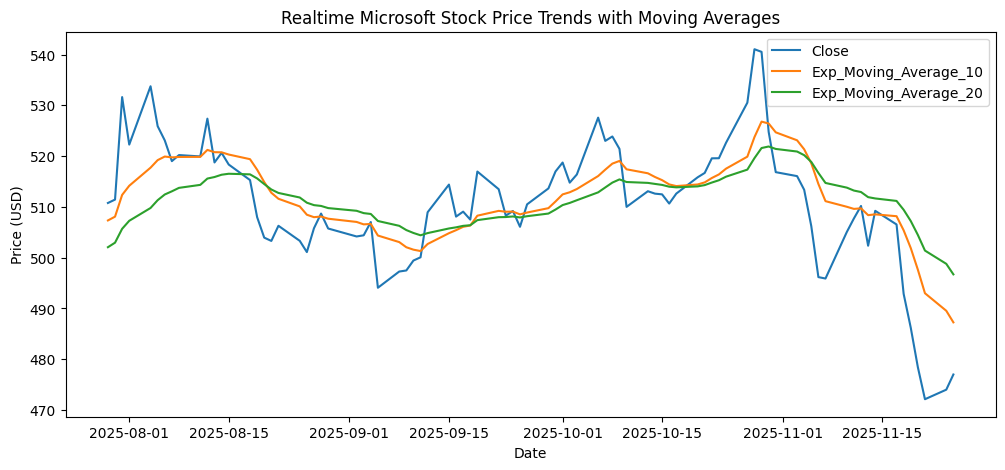

In [72]:
plt.figure(figsize=(12,5))
plt.plot(realtime_df.index,realtime_df["Close"], label="Close")
plt.plot(realtime_df.index,realtime_df["Exp_Moving_Average_10"], label="Exp_Moving_Average_10")
plt.plot(realtime_df.index,realtime_df["Exp_Moving_Average_20"], label="Exp_Moving_Average_20")
plt.title("Realtime Microsoft Stock Price Trends with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# Realtime Price Trends over Time

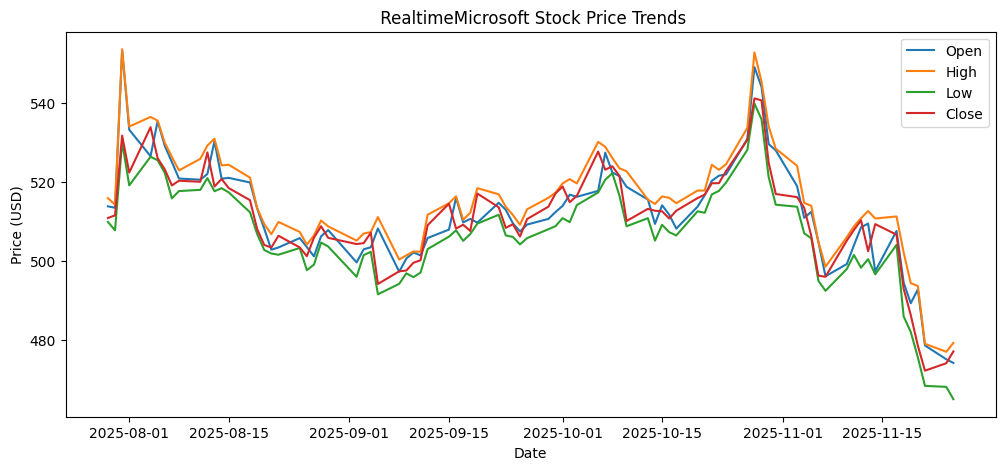

In [73]:
plt.figure(figsize=(12,5))
plt.plot(realtime_df.index,realtime_df["Open"], label="Open")
plt.plot(realtime_df.index,realtime_df["High"], label="High")
plt.plot(realtime_df.index,realtime_df["Low"], label="Low")
plt.plot(realtime_df.index,realtime_df["Close"], label="Close")
plt.title(" RealtimeMicrosoft Stock Price Trends")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# Scatter: Realtime Price vs Realtime Volume

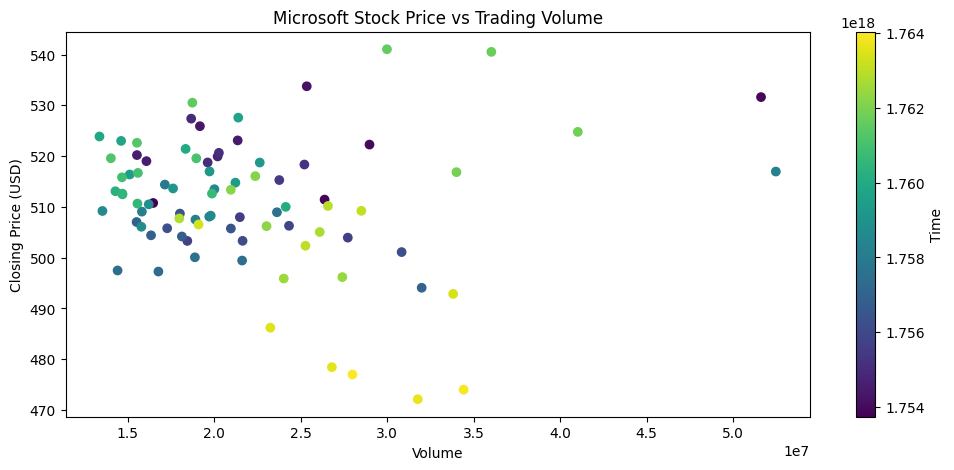

In [77]:
plt.figure(figsize=(12,5))
plt.scatter(realtime_df["Volume"],realtime_df["Close"], c=realtime_df.index)
plt.colorbar(label="Time")
plt.title("Microsoft Stock Price vs Trading Volume")
plt.xlabel("Volume")
plt.ylabel("Closing Price (USD)")
#plt.legend()
plt.show()

### Dropping Null values before scaling

In [ ]:
df=df.dropna(axis=0)

### Same features as training

In [34]:
realtime_close_data= realtime_df["Close"].values

sc_realtime_close= MinMaxScaler(feature_range=(0,1))

realtime_close_scaled= sc_realtime_close.fit_transform(realtime_close_data.reshape(-1,1))
print("Realtime Data Scaling done successfully")

Realtime Data Scaling done successfully


In [35]:
len(realtime_df)

85

# Create Sequences for training the LSTM Model with Realtime Data 

In [50]:
X_realtime_close_seq, Y_realtime_close_seq= create_univariate_sequences(realtime_close_scaled, time_steps=30)
print("Shape of realtime features sequences:", X_realtime_close_seq.shape)
print("Shape of realtime target sequences:", Y_realtime_close_seq.shape)

Shape of realtime features sequences: (55, 30)
Shape of realtime target sequences: (55, 1)


# Preparing Training and Testing Set

In [51]:
X_realtime_close_seq=X_realtime_close_seq.reshape((X_realtime_close_seq.shape[0],X_realtime_close_seq.shape[1],1))
split_ratio=0.8
split_length=int(len(X_realtime_close_seq)*split_ratio)

X_realtime_train_close, X_realtime_test_close = X_realtime_close_seq[:split_length], X_realtime_close_seq[split_length:]
Y_realtime_train_close, Y_realtime_test_close = Y_realtime_close_seq[:split_length], Y_realtime_close_seq[split_length:]

print(f"{X_realtime_train_close.shape[0]} samples")
print(f"{X_realtime_test_close.shape[0]} samples")

44 samples
11 samples


In [52]:
print(X_realtime_train_close.shape[1])

30


# Building the new Model for realtime data, keeping the architecture exactly same as used for training historical data

I CANNOT use the existing model, new model MUST be retrained.
The Math That Proves It.

Old Model:
Scaler trained on: [27.87, 95.01] in units of USD

When you feed it 472.12 USD: 
  scaled_value = (472.12 - 27.87) / (95.01 - 27.87) = 6.61 ← Should be 0-1!

LSTM expects: [0, 1]
LSTM gets: 6.61
Result: Complete failure 

New Model (Retrained):
Scaler trained on: [472.12, 541.06]
When you feed it 472.12:
  scaled_value = (472.12 - 472.12) / (541.06 - 472.12) = 0.0 

LSTM expects: [0, 1]
LSTM gets: 0.0
Result: Perfect!

In [39]:
realtime_uni_model=Sequential()

#First LSTM Layer having 
realtime_uni_model.add(LSTM(units=128, return_sequences=True, input_shape=(X_realtime_train_close.shape[1],1)))
realtime_uni_model.add(Dropout(0.2))

#Second LSTM Layer- refines pattens
realtime_uni_model.add(LSTM(units=64, return_sequences=True))
realtime_uni_model.add(Dropout(0.2))

#Third LSTM Layer- further compression
realtime_uni_model.add(LSTM(units=32, return_sequences=False))
realtime_uni_model.add(Dropout(0.2))

#Dense Layer (Hidden)- For final processing and improves performance
realtime_uni_model.add(Dense(units=16, activation="relu"))

#Output Layer- Gives one output
realtime_uni_model.add(Dense(1))

#Compile with Adam Optimizer
realtime_uni_model.compile(optimizer="adam",loss="mean_squared_error",metrics=["mae"])

print("Univariate LSTM Architecture Created for Realtime Stcok Market Prices")

Univariate LSTM Architecture Created for Realtime Stcok Market Prices


In [40]:
print("Univariate Realtime LSTM Model Architecture")
realtime_uni_model.summary()

Univariate Realtime LSTM Model Architecture
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 15, 128)           66560     
                                                                 
 dropout_3 (Dropout)         (None, 15, 128)           0         
                                                                 
 lstm_4 (LSTM)               (None, 15, 64)            49408     
                                                                 
 dropout_4 (Dropout)         (None, 15, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (

## Training Part- Calling the Model and fitting it again with realtime data

In [53]:
early_stopping=EarlyStopping(monitor="val_loss",patience=20, restore_best_weights=True,verbose=1)

realtime_model_history= realtime_uni_model.fit( X_realtime_train_close, Y_realtime_train_close, epochs=150, batch_size=16, validation_split=0.2, callbacks=[early_stopping], verbose=1)
print("\nUnivariate Model Training Completed with Realtime Stock Market Price")

Epoch 1/150
3/3 [==============================] - 12s 2s/step - loss: 0.0560 - mae: 0.1928 - val_loss: 0.0375 - val_mae: 0.1543
Epoch 2/150
3/3 [==============================] - 0s 114ms/step - loss: 0.0347 - mae: 0.1458 - val_loss: 0.0577 - val_mae: 0.1869
Epoch 3/150
3/3 [==============================] - 0s 104ms/step - loss: 0.0631 - mae: 0.1998 - val_loss: 0.0406 - val_mae: 0.1602
Epoch 4/150
3/3 [==============================] - 0s 110ms/step - loss: 0.0304 - mae: 0.1365 - val_loss: 0.0386 - val_mae: 0.1565
Epoch 5/150
3/3 [==============================] - 0s 112ms/step - loss: 0.0231 - mae: 0.1167 - val_loss: 0.0420 - val_mae: 0.1631
Epoch 6/150
3/3 [==============================] - 0s 110ms/step - loss: 0.0312 - mae: 0.1422 - val_loss: 0.0452 - val_mae: 0.1749
Epoch 7/150
3/3 [==============================] - 0s 109ms/step - loss: 0.0226 - mae: 0.1167 - val_loss: 0.0412 - val_mae: 0.1607
Epoch 8/150
3/3 [==============================] - 0s 118ms/step - loss: 0.0219 - mae

# Evaluating the Realtime LSTM Model by predicting on test values

In [54]:
Y_realtime_pred_scaled= realtime_uni_model.predict(X_realtime_test_close)
print("Predictions Completed")

1/1 [==============================] - 3s 3s/step
Predictions Completed


## Taking Inverse to get back actual realtime prices

In [55]:
Y_realtime_pred_close= sc_realtime_close.inverse_transform(Y_realtime_pred_scaled.reshape(-1,1))
Y_realtime_test_close_actual= sc_realtime_close.inverse_transform(Y_realtime_test_close.reshape(-1,1))
print("Inverse Scaling Done")

Inverse Scaling Done


In [56]:
print("Scaling Information\n")
print(f"Range of Scaler of Close-({sc_close.data_min_},{sc_close.data_max_})")

Scaling Information

Range of Scaler of Close-([27.87],[95.01])


In [57]:
print(f"Range of Predictions-{Y_realtime_pred_close.min()},{Y_realtime_pred_close.max()}")
print(f"Range of Actual Close Prices- {Y_realtime_test_close_actual.min()},{Y_realtime_test_close_actual.max()}")

Range of Predictions-512.212158203125,512.320068359375
Range of Actual Close Prices- 472.11999511718744,510.1851501464844


# Calculating Realtime Evaluation Metrics

In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae_realtime= mean_absolute_error(Y_realtime_test_close_actual, Y_realtime_pred_close)
rmse_realtime= np.sqrt(mean_squared_error(Y_realtime_test_close_actual, Y_realtime_pred_close))
r2_realtime= r2_score(Y_realtime_test_close_actual, Y_realtime_pred_close)

print("Model Evaluation Metrics")
print("\nMean Absolute Error=", mae_realtime)
print("\nRoot Mean Squared Error=", rmse_realtime)
print("\nR2 Score=", r2_realtime)

Model Evaluation Metrics

Mean Absolute Error= 19.84330610795455

Root Mean Squared Error= 24.640344664446367

R2 Score= -1.836596472686911


Insufficient Data (R² = -1.8365):

Learned data requirements for deep learning
Understood minimum viable dataset sizes
Recognized when to recommend alternative approaches
Gained experience in honest limitation assessment

LSTM needs: 200+ data points minimum
I have: 85 data points- this is WAY too small for LSTM deep learning!
Result: Model can't learn patterns, just predicts average = flat line

# Visualize Actual vs Predicted Stock Prices on Realtime Data

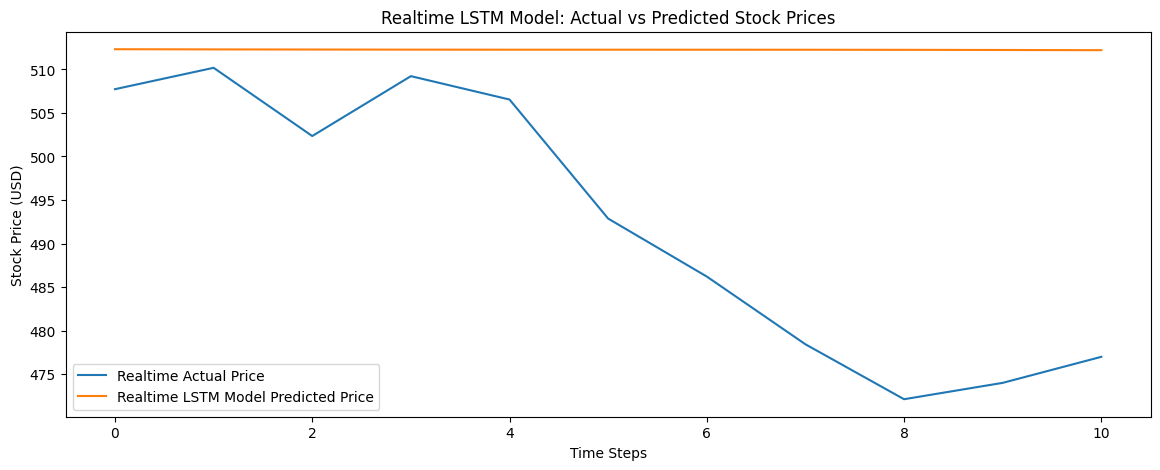

In [59]:
plt.figure(figsize=(14,5))
plt.plot(Y_realtime_test_close_actual,label="Realtime Actual Price")
plt.plot(Y_realtime_pred_close,label="Realtime LSTM Model Predicted Price")
plt.title("Realtime LSTM Model: Actual vs Predicted Stock Prices")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()

The model has given up and is just outputting the average price because it doesn't have enough data to learn.

CONCLUSION

This Microsoft Stock Price Prediction project provided comprehensive hands-on experience in applying deep learning to financial time series forecasting. Despite encountering multiple critical challenges—ranging from data scaling issues to architectural bottlenecks to insufficient real-time data—demonstrated strong problem-solving capabilities, technical depth, and professional maturity.

Realtime Prediction for next 30 days is skipped for this realtime Stcok Price Prediction since, very few datapoints are present which will completely give wrong predictions